In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt

import h5py
import sys
sys.path.append('../')
import analysis_utils as utils

from scipy.optimize import curve_fit
from scipy.special import erf
from scipy.signal import decimate

yale_colors = ['#00356b', '#286dc0', '#63aaff', '#4a4a4a']
utils.load_plotting_setting()

from matplotlib.gridspec import GridSpec
from matplotlib.ticker import LogLocator, NullFormatter, MultipleLocator

In [2]:
c_mv = 8.263269630174246e-08
amp2kev = 7157.624533259538

## Make a nice figure

/var/folders/mb/1ggr_wms5jz0l7fkkc3b9xg80000gn/T/ipykernel_20472/1292840068.py:18: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


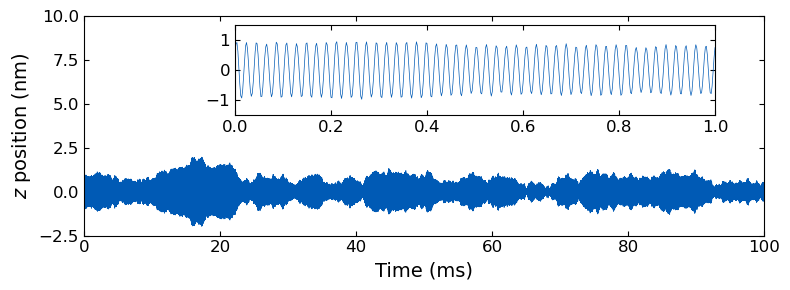

In [28]:
window_length = 5000
f = h5py.File('/Volumes/LaCie/dm_data/sphere_20250103/20250111_1e-8mbar_8e_alignment1_long/20250111_d_17.hdf5', 'r')

dtt = f['data'].attrs['delta_t']
fs = int(np.ceil(1 / dtt))   # Sampling rate at Hz
zz = f['data']['channel_d'][:] * f['data']['channel_d'].attrs['adc2mv'] / 1e3  # Signal in V

zz_bp = utils.bandpass_filtered(zz, fs, 30000, 80000)

zz_shaped = np.reshape(zz, (int(zz.size / window_length), window_length))
zz_bp_shaped = np.reshape(zz_bp, (int(zz_bp.size / window_length), window_length))

f.close()

fig, ax = plt.subplots(1, 1, figsize=(8, 3))

tt = np.arange(0, zz_bp.size) * 2e-6
ax.plot((tt-20) / 1e-3, zz_bp * c_mv/1e-9, color='#005AB5', linewidth=0.5)

ax.set_xlim(0, 100)
ax.set_ylim(-2.5, 10)
ax.set_xlabel('Time (ms)')
ax.set_ylabel('$z$ position (nm)')

left, bottom, width, height = [0.3, 0.6, 0.6, 0.3]
ax2 = fig.add_axes([left, bottom, width, height])

ax2.plot((tt-20) / 1e-3, zz_bp * c_mv/1e-9, color='#005AB5', linewidth=0.5)
ax2.set_xlim(0, 1)
ax2.set_ylim(-1.5, 1.5)

fig.tight_layout()


In [35]:
from scipy.signal import welch
ff, pp = welch(zz, fs=500000, nperseg=2**11)

Text(0, 0.5, 'Amplitude spectral density (m/$\\sqrt{\\mathrm{Hz}}$)')

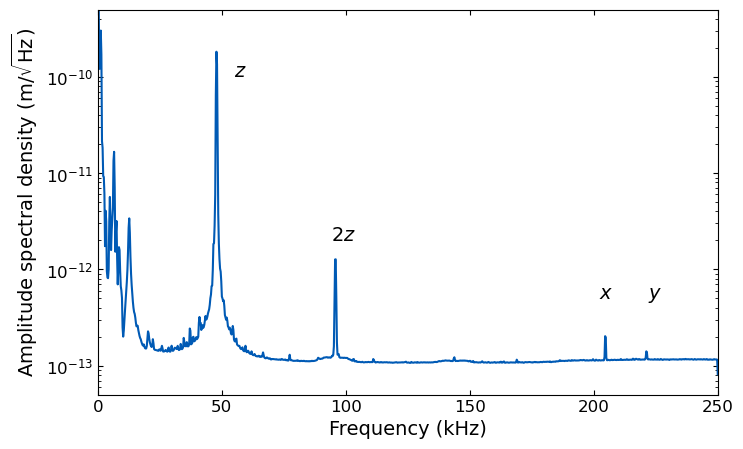

In [55]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

ax.plot(ff/1000, np.sqrt(pp)*c_mv, color='#005AB5')
ax.set_yscale('log')
ax.set_xlim(0, 250)
ax.set_ylim(5e-14, 5e-10)

ax.text(55, 1e-10, r'$z$', fontsize=14)
ax.text(94, 2e-12, r'$2z$', fontsize=14)

ax.text(202, 5e-13, r'$x$', fontsize=14)
ax.text(222, 5e-13, r'$y$', fontsize=14)

ax.set_xlabel('Frequency (kHz)')
ax.set_ylabel(r'Amplitude spectral density (m/$\sqrt{\mathrm{Hz}}$)')


## Example events rejected by each data cut

In [ ]:
f = h5py.File('/Volumes/LaCie/dm_data_processed_amp_chisquare/sphere_20250103/20250104_4e-8mbar_alignment0_long/20250104_d_220_processed.hdf5', 'r')
amplitude = f['data_processed']['amplitude'][:]
idx_in_window = f['data_processed']['idx_in_window'][:]
good_detection = f['data_processed']['good_detection'][:]
noise_level_amp = f['data_processed']['noise_level_amp'][:]
chisquare_short = f['data_processed']['chisquare_short'][:]
f.close()

f = h5py.File('/Volumes/LaCie/dm_data_processed_fullamp/sphere_20250103/20250104_4e-8mbar_alignment0_long/20250104_d_220_processed.hdf5', 'r')
fullamp = f['data_processed']['amplitude'][:]
f.close()

window_length = 5000
f = h5py.File('/Volumes/LaCie/dm_data/sphere_20250103/20250104_4e-8mbar_alignment0_long/20250104_d_220.hdf5', 'r')

dtt = f['data'].attrs['delta_t']
fs = int(np.ceil(1 / dtt))   # Sampling rate at Hz
zz = f['data']['channel_d'][:] * f['data']['channel_d'].attrs['adc2mv'] / 1e3  # Signal in V

zz_bp = utils.bandpass_filtered(zz, fs, 30000, 80000)

zz_shaped = np.reshape(zz, (int(zz.size / window_length), window_length))
zz_bp_shaped = np.reshape(zz_bp, (int(zz_bp.size / window_length), window_length))

f.close()

#### Detection quality examples

<>:16: SyntaxWarning: invalid escape sequence '\m'
<>:17: SyntaxWarning: invalid escape sequence '\m'
<>:16: SyntaxWarning: invalid escape sequence '\m'
<>:17: SyntaxWarning: invalid escape sequence '\m'
/var/folders/mb/1ggr_wms5jz0l7fkkc3b9xg80000gn/T/ipykernel_5882/2795621911.py:16: SyntaxWarning: invalid escape sequence '\m'
  axes[0].set_xlabel('Time ($\mu$s)')
/var/folders/mb/1ggr_wms5jz0l7fkkc3b9xg80000gn/T/ipykernel_5882/2795621911.py:17: SyntaxWarning: invalid escape sequence '\m'
  axes[1].set_xlabel('Time ($\mu$s)')


Text(0.5, 0.98, 'Detection quality cut (20250104_4e-8mbar_alignment0_long)')

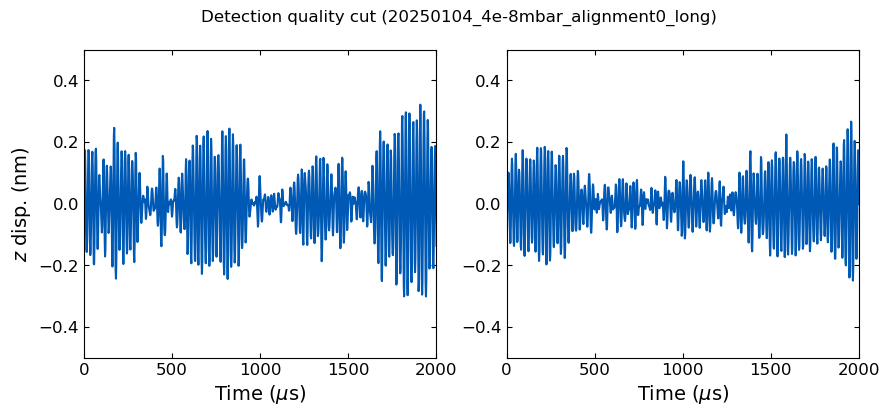

In [15]:
bad_window_idx = np.nonzero(~good_detection)[0]

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

tt0 = np.arange(0, window_length) * dtt / 1e-6 - 400
axes[0].plot(tt0, zz_bp_shaped[bad_window_idx[4]] * c_mv / 1e-9, color='#005AB5')
axes[0].set_ylim(-0.5, 0.5)
axes[0].set_xlim(0, 2000)

tt1 = np.arange(0, window_length) * dtt / 1e-6 - 5000
axes[1].plot(tt1, zz_bp_shaped[bad_window_idx[8]] * c_mv / 1e-9, color='#005AB5')
axes[1].set_ylim(-0.5, 0.5)
axes[1].set_xlim(0, 2000)

axes[0].set_ylabel('$z$ disp. (nm)')
axes[0].set_xlabel('Time ($\mu$s)')
axes[1].set_xlabel('Time ($\mu$s)')

fig.suptitle(f'Detection quality cut (20250104_4e-8mbar_alignment0_long)')

#### Noise level examples

<>:16: SyntaxWarning: invalid escape sequence '\m'
<>:16: SyntaxWarning: invalid escape sequence '\m'
/var/folders/mb/1ggr_wms5jz0l7fkkc3b9xg80000gn/T/ipykernel_5882/39233046.py:16: SyntaxWarning: invalid escape sequence '\m'
  ax.set_xlabel('Time ($\mu$s)')


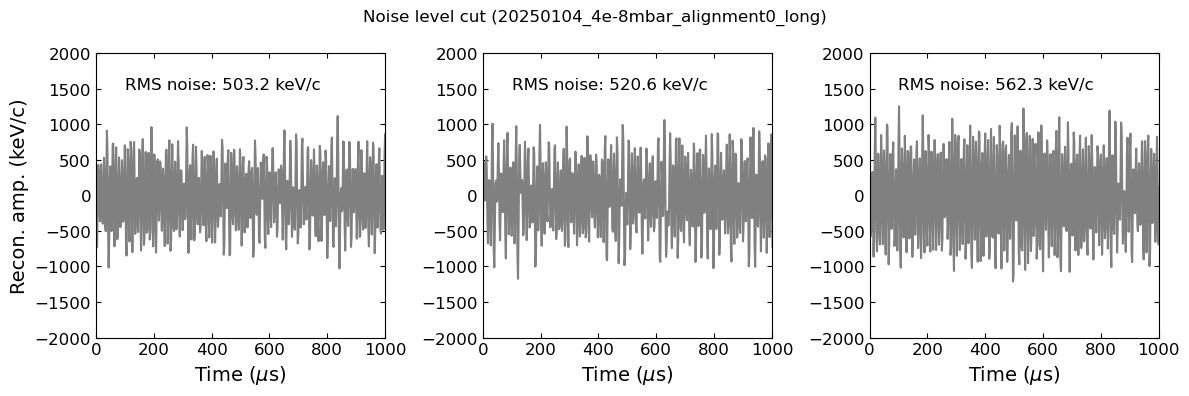

In [16]:
bad_window_idx = np.nonzero(noise_level_amp * amp2kev > 500)[0]

fig, axes = plt.subplots(1, 3, figsize=(12, 4))

for i, ax in enumerate(axes):
    tt0 = np.arange(0, window_length) * dtt / 1e-6 - 500
    ax.plot(tt0, fullamp[bad_window_idx[i]] * amp2kev, color='grey')
    ax.text(100, 1500, f'RMS noise: {noise_level_amp[bad_window_idx[i]] * amp2kev:.1f} keV/c', fontsize=12)

# tt1 = np.arange(0, window_length) * dtt / 1e-6 - 500
# axes[1].plot(tt1, fullamp[bad_window_idx[1]] * amp2kev, color='grey')

for ax in axes:
    ax.set_ylim(-2000, 2000)
    ax.set_xlim(0, 1000)
    ax.set_xlabel('Time ($\mu$s)')

axes[0].set_ylabel('Recon. amp. (keV/c)')

fig.suptitle(f'Noise level cut (20250104_4e-8mbar_alignment0_long)')
fig.tight_layout()

Examples of good windows

<>:13: SyntaxWarning: invalid escape sequence '\m'
<>:13: SyntaxWarning: invalid escape sequence '\m'
/var/folders/mb/1ggr_wms5jz0l7fkkc3b9xg80000gn/T/ipykernel_1988/1845819210.py:13: SyntaxWarning: invalid escape sequence '\m'
  ax.set_xlabel('Time ($\mu$s)')


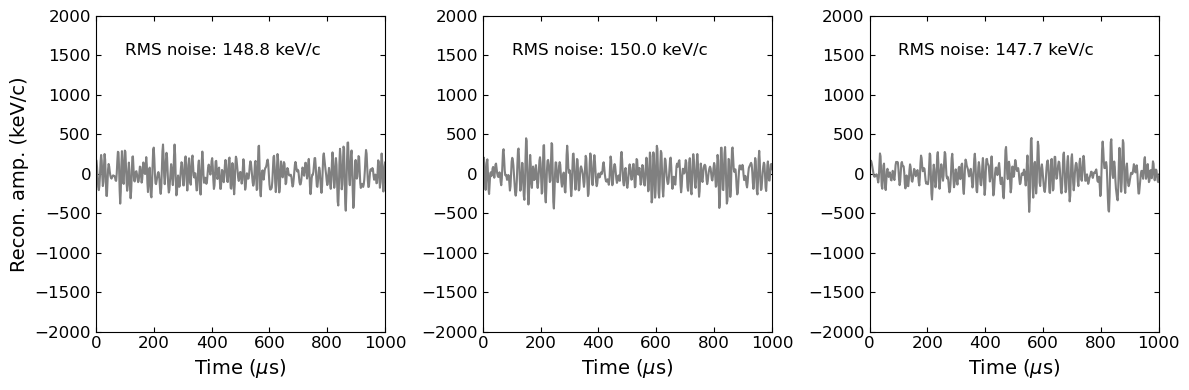

In [324]:
good_window_idx = np.nonzero(noise_level_amp * amp2kev < 150)[0]

fig, axes = plt.subplots(1, 3, figsize=(12, 4))

for i, ax in enumerate(axes):
    tt0 = np.arange(0, window_length) * dtt / 1e-6 - 500
    ax.plot(tt0, fullamp[good_window_idx[i]] * amp2kev, color='grey')
    ax.text(100, 1500, f'RMS noise: {noise_level_amp[good_window_idx[i]] * amp2kev:.1f} keV/c', fontsize=12)

for ax in axes:
    ax.set_ylim(-2000, 2000)
    ax.set_xlim(0, 1000)
    ax.set_xlabel('Time ($\mu$s)')

axes[0].set_ylabel('Recon. amp. (keV/c)')

# fig.suptitle(f'Noise level cut (20250104_4e-8mbar_alignment0_long)')
fig.tight_layout()

#### $\chi^2$ cut examples

In [245]:
def get_amp_waveform(amps, amp_indices, bad_amp_idx, length=50):
    amps_window = amps[bad_amp_idx[0]]
    idx_in_window = amp_indices[*bad_amp_idx]
    ret = amps_window[idx_in_window-int(length/2) : idx_in_window+int(length/2)]

    return ret

def get_normalized_template(sphere, voltage, bounds=(1000, 2000), downsampled=False):
    pulse_shape_file = np.load(rf'/Users/yuhan/work/nanospheres/dm_nanospheres/data_processed/pulse_shape/{sphere}_pulse_shape_template_{voltage}v.npz')
    pulse_shapes = pulse_shape_file['pulse_shape']
    pulse_shape_template = np.mean(pulse_shapes, axis=0)

    normalized_template = pulse_shape_template / np.max(pulse_shape_template)

     # Take the central values around the peak
    ret = normalized_template[bounds[0]:bounds[1]]

    # Downsample to 500 kHz (so the 200 us template has 100 indices)
    if downsampled:
        ret_downsampled = decimate(ret, 10)
        return ret_downsampled / np.max(ret_downsampled)
    else:
        return ret

In [ ]:
good_noise = (noise_level_amp * amp2kev) < 400
good_det_noise = np.logical_and(good_detection, good_noise)

# Pick out waveforms that pass the detection and noise cut
# chi2 = 400 is for plotting only -- the actual threshold is 150
bad_chi2 = np.asarray(np.nonzero(chisquare_short > 400))

bad_chi2_idx = []
for i, bad_chi2_window in enumerate(bad_chi2[0]):
    if good_det_noise[bad_chi2_window]:
        bad_chi2_idx.append(np.asarray([bad_chi2[0][i], bad_chi2[1][i]]))

bad_chi2_idx = np.asarray(bad_chi2_idx)

<>:9: SyntaxWarning: invalid escape sequence '\c'
<>:9: SyntaxWarning: invalid escape sequence '\c'
/var/folders/mb/1ggr_wms5jz0l7fkkc3b9xg80000gn/T/ipykernel_1988/1228089737.py:9: SyntaxWarning: invalid escape sequence '\c'
  ax.text(-40, 1500, f'$\chi^2 = $ {chisquare_short[*bad_chi2_idx[i]]:.1f}')


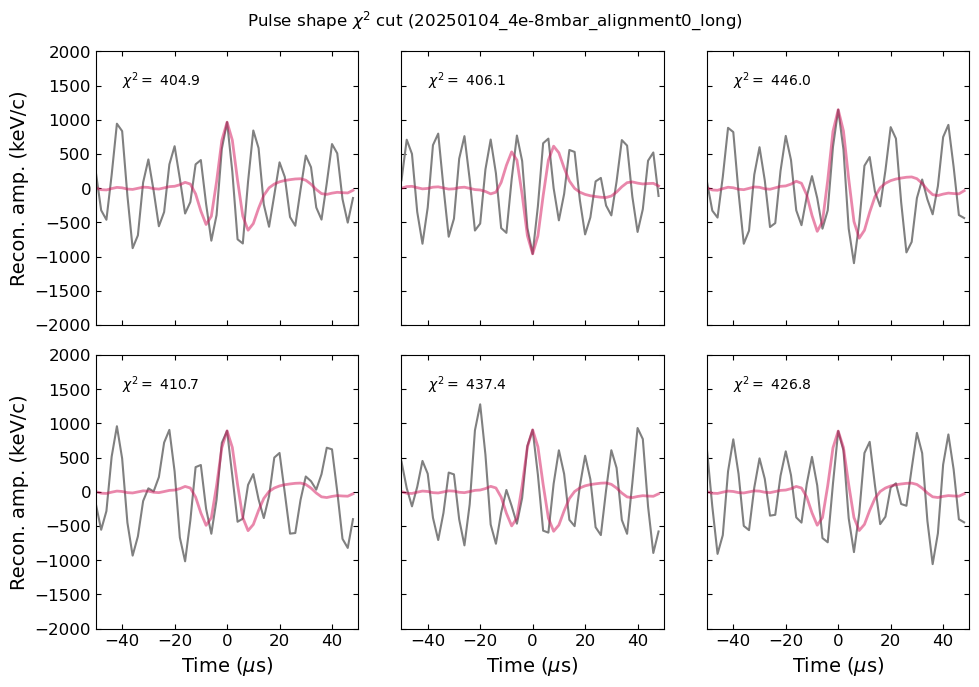

In [292]:
normalized_template_downsampled_short = get_normalized_template('sphere_20250103', voltage=20, bounds=(1250, 1750), downsampled=True)

fig, axes = plt.subplots(2, 3, figsize=(10, 7))

for i, ax in enumerate(axes.flatten()):
    tt0 = np.arange(0, 50) * dtt / 1e-6 - 50
    bad_waveform0 = get_amp_waveform(fullamp, idx_in_window, bad_chi2_idx[i], length=50)

    ax.text(-40, 1500, f'$\chi^2 = $ {chisquare_short[*bad_chi2_idx[i]]:.1f}')
    ax.plot(tt0, bad_waveform0 * amp2kev, color='grey')
    ax.plot(tt0, normalized_template_downsampled_short * bad_waveform0[25] * amp2kev, color='#D41159', alpha=0.5, linewidth=2)

for ax in axes.flatten():
    ax.set_ylim(-2000, 2000)
    ax.set_xlim(-50, 50)

for ax in [axes[0, 1], axes[0, 2], axes[1, 1], axes[1, 2]]:
    ax.set_yticklabels([])

for ax in axes[0]:
    ax.set_xticklabels([])

for ax in [axes[0, 0], axes[1, 0]]:
    ax.set_ylabel('Recon. amp. (keV/c)')
for ax in axes[1]:
    ax.set_xlabel(r'Time ($\mu$s)')

fig.suptitle(fr'Pulse shape $\chi^2$ cut (20250104_4e-8mbar_alignment0_long)', y=0.975)
fig.tight_layout()
fig.align_labels()


## Time dependence of isolated pulses

In [447]:
np.concatenate([np.array([1, 1, 1]), np.array([2, 2, 2])], axis=0)

array([1, 1, 1, 2, 2, 2])

First look at pulses larger than 1 MeV (this is the analysis threshold that we will use). After the $\chi^2$ cut we expect them to be actual isolated pulses.

In [245]:
idx = 500

f = h5py.File(f'/Volumes/LaCie/dm_data_processed_amp_chisquare/sphere_20250103/20250104_4e-8mbar_alignment0_long/20250104_d_{idx}_processed.hdf5', 'r')
amplitude = f['data_processed']['amplitude'][:]
idx_in_window = f['data_processed']['idx_in_window'][:]
good_detection = f['data_processed']['good_detection'][:]
noise_level_amp = f['data_processed']['noise_level_amp'][:]
chisquare_short = f['data_processed']['chisquare_short'][:]
f.close()

amp_thr = 1000
noise_thr = 400
chi2_thr_short = 150

good_noise = (noise_level_amp * amp2kev) < noise_thr
good_det_noise = np.logical_and(good_detection, good_noise)

amplitude_short = np.copy(amplitude)
bad_chi2_short = (chisquare_short > chi2_thr_short)
amplitude_short[bad_chi2_short] = np.nan

pulse_window_idx = np.nonzero(np.logical_and(np.abs(amplitude_short) * amp2kev > amp_thr, np.tile(good_det_noise, (194, 1)).T))

In [246]:
window_length = 5000
f = h5py.File(f'/Volumes/LaCie/dm_data/sphere_20250103/20250104_4e-8mbar_alignment0_long/20250104_d_{idx}.hdf5', 'r')

dtt = f['data'].attrs['delta_t']
fs = int(np.ceil(1 / dtt))   # Sampling rate at Hz
zz = f['data']['channel_d'][:] * f['data']['channel_d'].attrs['adc2mv'] / 1e3  # Signal in V

zz_bp = utils.bandpass_filtered(zz, fs, 30000, 80000)

zz_shaped = np.reshape(zz, (int(zz.size / window_length), window_length))
zz_bp_shaped = np.reshape(zz_bp, (int(zz_bp.size / window_length), window_length))

<>:24: SyntaxWarning: invalid escape sequence '\m'
<>:24: SyntaxWarning: invalid escape sequence '\m'
/var/folders/mb/1ggr_wms5jz0l7fkkc3b9xg80000gn/T/ipykernel_5882/1516462692.py:24: SyntaxWarning: invalid escape sequence '\m'
  ax.set_xlabel('Time ($\mu$s)')


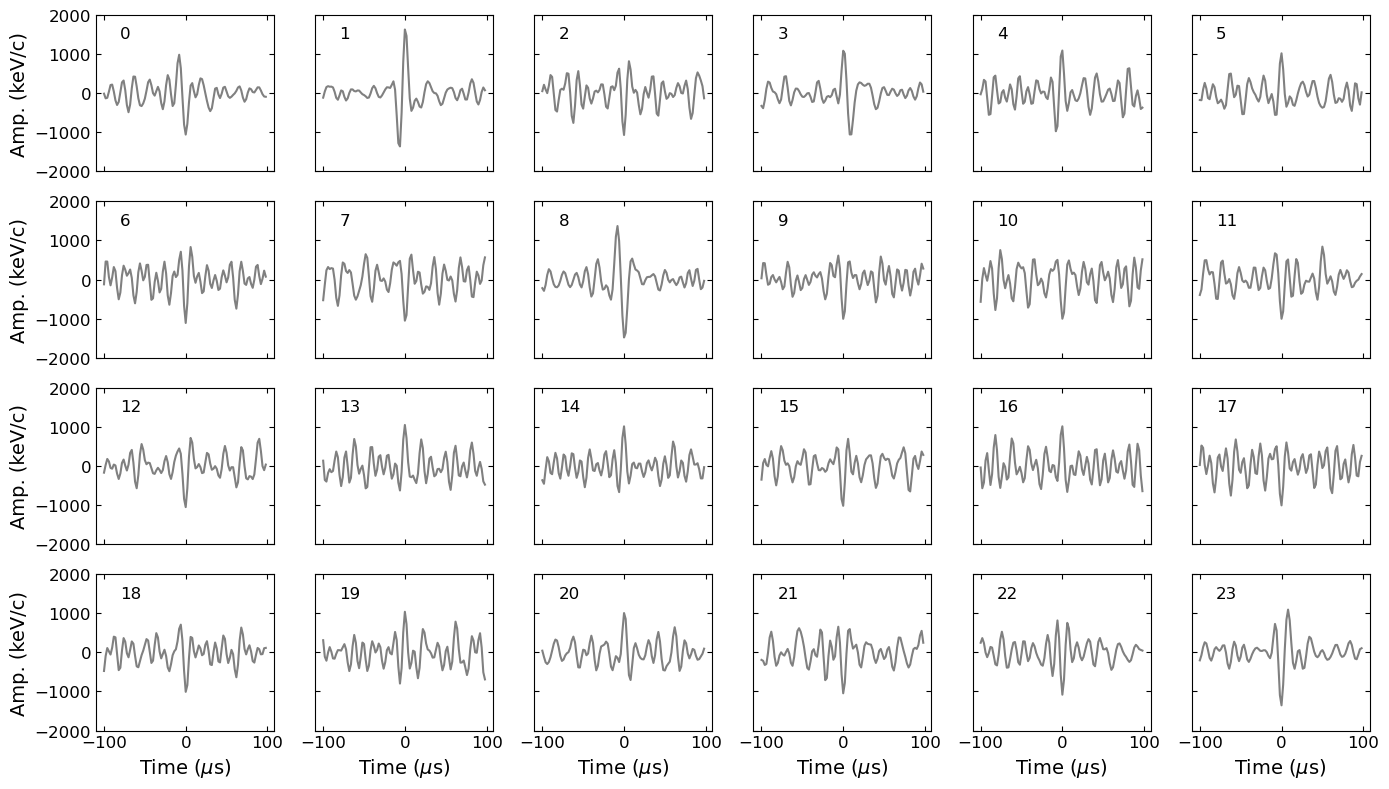

In [247]:
fig, axes = plt.subplots(4, 6, figsize=(14, 8))

searched_idx_in_window = idx_in_window[pulse_window_idx]
for i in range(24):
    ax = axes.flatten()[i]

    _zz_bp = zz_bp_shaped[pulse_window_idx[0][i]]
    _amp, amp_lp, temp = utils.recon_force(dtt, _zz_bp, c_mv=None)

    # idx_pulse = np.argmax(np.abs(amp_lp[100:-50])) + 100
    idx_pulse = searched_idx_in_window[i]

    tt = (np.arange(0, 100) - 50) * 2
    ax.plot(tt, amp_lp[idx_pulse - 50 : idx_pulse + 50] * amp2kev, color='grey')
    ax.text(-80, 1400, f'{i}', fontsize=12)

    if i % 6 != 0:
        ax.set_yticklabels([])
    else:
        ax.set_ylabel('Amp. (keV/c)')
    if i < 18:
        ax.set_xticklabels([])
    else:
        ax.set_xlabel('Time ($\mu$s)')
    ax.set_ylim(-2000, 2000)

fig.tight_layout()
fig.align_labels()

In [449]:
f = h5py.File('/Users/yuhan/work/nanospheres/data/dm_data_processed_amp_chisquare/sphere_20250103/20250104_4e-8mbar_alignment0_long/20250104_4e-8mbar_alignment0_long_pulse_waveforms.hdf5', 'r')

In [ ]:
waveforms = f['pulses']['pulse_waveform'][:]

In [473]:
np.diff(f['pulses']['pulse_time'][:])

array([4.83581781e-01, 1.45180225e-02, 5.21299839e-02, 1.82120800e-02,
       7.12556124e-01, 7.48620033e-02, 1.01720190e+00, 3.23541880e-01,
       1.11286163e-01, 4.67525959e-01, 1.50559902e-01, 4.81486082e-01,
       8.43107939e-01, 3.07909966e-01, 2.97212601e-03, 3.68599892e-02,
       1.44479275e-02, 8.39140415e-02, 6.24351978e-01, 2.11060047e-02,
       8.15460682e-02, 5.04390001e-01, 8.63287926e-01, 1.20853996e+00,
       5.59218168e-01, 2.91005850e-01, 3.51439953e-01, 3.19440365e-02,
       3.61320972e-02, 5.72359562e-02, 1.45031929e-01, 6.13674164e-01,
       4.24741983e-01, 3.26364040e-01, 3.34279537e-02, 1.33712053e-01,
       6.70979023e-02, 7.49800205e-02, 5.72407961e-01, 6.37180805e-02,
       3.41902018e-01, 2.07229853e-01, 1.82729959e-01, 9.31000710e-03,
       1.54721737e-02, 3.70559931e-01, 1.44205809e+00, 6.63719893e-01,
       1.24949408e+00, 3.58747959e-01, 2.68372059e-01, 1.42922997e+00,
       1.29699707e-02, 6.68978691e-02, 5.34720421e-02, 1.57101154e-02,
      

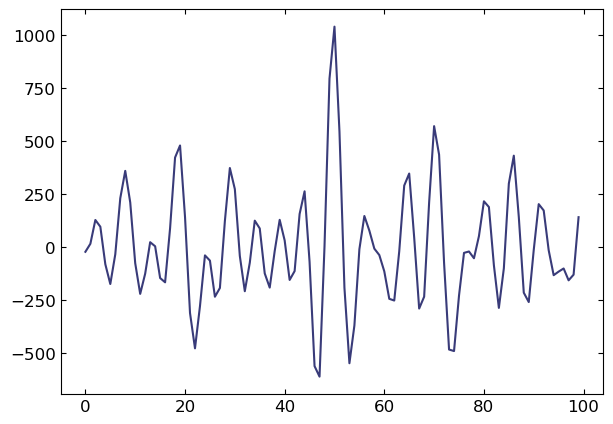

In [468]:
plt.plot(waveforms[300] * amp2kev)

In [431]:
f['summed_histograms']['hh_det_noise_chi2_short_sum'][:]

array([[     0,     12,    563,   6024,  24754,  56760,  87655, 102554,
         97066,  78547,  55720,  35768,  21335,  11395,   5701,   2751,
          1247,    502,    210,     82,     37,     20,      7,      9,
             1,      1,      2,      3,      0,      0,      2,      0,
             0,      1,      1,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0, 

In [448]:
f.close()

In [396]:
np.isnan(np.nan)

True

In [403]:
def throw_away_doublecounts(amplitude_short, good_det_noise, amp_thr, double_count_idx_thr=7):
    ret = np.copy(amplitude_short)

    # Pulse above threshold in good time windows
    large_pulses = np.logical_and(np.abs(ret) * amp2kev > amp_thr, np.tile(good_det_noise, (194, 1)).T)

    # Identify pulses less than 7 indices apart
    small_diff_large_pulses = np.abs(np.diff(idx_in_window[large_pulses], append=5000)) < double_count_idx_thr

    large_pulses_pos = np.asarray(np.nonzero(large_pulses)).T
    amplitude_large_pulses = ret[large_pulses]

    for i, indices in enumerate(large_pulses_pos):
        # Keep the larger value of two nearby pulses above threshold
        # and set the other to nan
        if small_diff_large_pulses[i]:
            if np.isnan(amplitude_large_pulses[i]):
                continue

            # If the two amplitudes are from the same pulse, we expect them
            # to be different in sign
            if amplitude_large_pulses[i] * amplitude_large_pulses[i+1] > 1:
                continue

            if np.abs(amplitude_large_pulses[i]) < np.abs(amplitude_large_pulses[i+1]):
                ret[ *large_pulses_pos[i] ] = np.nan
            else:
                ret[ *large_pulses_pos[i+1] ] = np.nan
    
    return ret


In [432]:
noise_thr = 400
chi2_thr_short = 150

with h5py.File(r'/Users/yuhan/work/nanospheres/data/dm_data_processed_amp_chisquare/sphere_20250103/20250104_4e-8mbar_alignment0_long/20250104_d_6_processed.hdf5', 'r') as f:
    timestamp = f['data_processed'].attrs['timestamp']

    amplitude = f['data_processed']['amplitude'][:]
    idx_in_window = f['data_processed']['idx_in_window'][:]

    good_detection = f['data_processed']['good_detection'][:]
    noise_level_amp = f['data_processed']['noise_level_amp'][:]
    chisquare_short = f['data_processed']['chisquare_short'][:]
    
    f.close()

good_noise = (noise_level_amp * amp2kev) < noise_thr
good_det_noise = np.logical_and(good_detection, good_noise)

amplitude_short = np.copy(amplitude)
bad_chi2_short = (chisquare_short > chi2_thr_short)
amplitude_short[bad_chi2_short] = np.nan

amplitude_short_corrected = throw_away_doublecounts(amplitude_short, good_det_noise, 1000, 7)



In [444]:
amp_thr = 1500
pulse_window_idx = np.nonzero(np.logical_and(np.abs(amplitude_short_corrected) * amp2kev > amp_thr, np.tile(good_det_noise, (194, 1)).T))

In [445]:
pulse_window_idx

(array([1384, 2517, 4455, 4965]), array([ 74,  13,  83, 157]))

In [415]:
amp_thr = 1500
pulse_window_idx_before_corr = np.nonzero(np.logical_and(np.abs(amplitude_short) * amp2kev > amp_thr, np.tile(good_det_noise, (194, 1)).T))
pulse_window_idx_after_corr = np.nonzero(np.logical_and(np.abs(amplitude_short_corrected) * amp2kev > amp_thr, np.tile(good_det_noise, (194, 1)).T))

print(pulse_window_idx_before_corr)
print(pulse_window_idx_after_corr)

(array([1384, 2517, 4455, 4965, 4965]), array([ 74,  13,  83, 157, 158]))
(array([1384, 2517, 4455, 4965]), array([ 74,  13,  83, 157]))


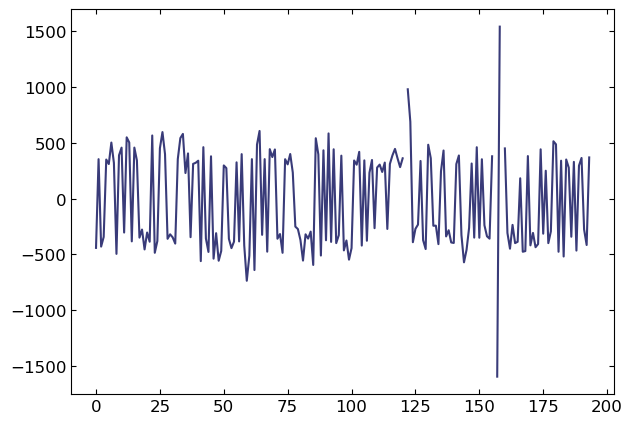

In [416]:
plt.plot(amplitude_short[4965] * amp2kev) 

In [418]:
amplitude_short_corrected[4965][150:160] * amp2kev

array([ -349.83876825,   353.55947688,  -238.19419161,  -337.20502674,
        -358.22618124,   379.96283187,            nan, -1594.84235833,
                  nan,            nan])

In [393]:
chisquare_short[4965][150:160]

array([ 54.38719914,  20.30274394,  40.88498086,  20.96570207,
        28.00064339,  39.53469196, 160.41421622,  98.12295404,
       127.4907412 , 192.79203609])

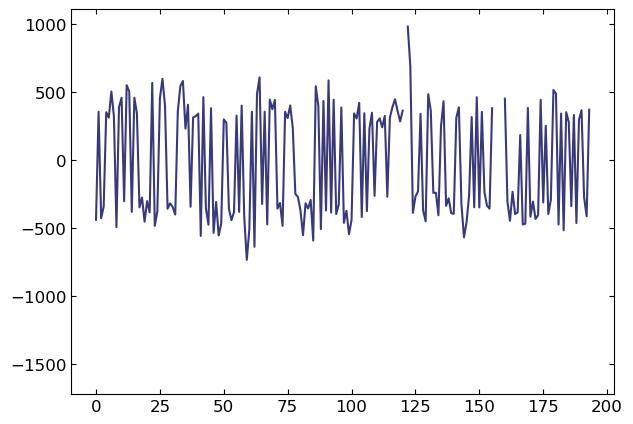

In [417]:
plt.plot(amplitude_short_corrected[4965] * amp2kev)

In [400]:
amplitude_short_corrected[2517] * amp2kev

array([-339.77754031,  471.1871259 , -691.37703575, -370.98229807,
        481.0463439 ,  426.17888041, -460.88773873, -512.6477046 ,
       -497.18032781, -587.39642797,  652.05389126, -439.88193851,
                 nan, 1523.36757471,           nan,  574.07449263,
       -314.77439554, -372.05578683,  425.74455975, -348.88159476,
        567.86350344, -373.68260166,  255.89919991,  562.40549681,
        583.81883976,  447.27805034, -451.81679152,  414.72467097,
       -271.87086894,  686.09579851,  898.97942706, -459.41986719,
        344.52369907, -438.88749701, -601.69405056, -453.08703467,
        654.32949354,  648.84572151,  265.60401315, -505.51534874,
       -464.08126485, -459.82409285,  400.78040158, -422.5828847 ,
       -508.17959314,  344.93299608,  313.69898504, -713.36450314,
        366.32132453, -252.89763852, -376.75923665, -376.38948534,
        434.16383593,  503.89360862, -690.21318658,  460.5819481 ,
       -490.08016135,  471.29742591, -387.47085912, -289.92914

In [3]:
def get_pulse_time(timestamp, idx_in_window, pulse_window_idx, window_length=5000, dtt=2e-6):
    pulse_idx_in_window = idx_in_window[pulse_window_idx]

    ret = (pulse_window_idx[0] * window_length + pulse_idx_in_window) * dtt
    return timestamp + ret

In [329]:
def get_pulse_time_dataset(sphere, dataset, data_prefix, nfile, amp_thr=1500, noise_thr=400, chi2_thr_short=150):
    data_dir = f'/Volumes/LaCie/dm_data_processed_amp_chisquare/{sphere}/{dataset}'

    file_idx, pulse_amp, pulse_time = [], [], []
    for i in range(nfile):
        file = os.path.join(data_dir, f'{data_prefix}{i}_processed.hdf5')
        f = h5py.File(file, 'r')

        timestamp = f['data_processed'].attrs['timestamp']
        amplitude = f['data_processed']['amplitude'][:]

        idx_in_window = f['data_processed']['idx_in_window'][:]
        good_detection = f['data_processed']['good_detection'][:]
        noise_level_amp = f['data_processed']['noise_level_amp'][:]
        chisquare_short = f['data_processed']['chisquare_short'][:]

        f.close()

        good_noise = (noise_level_amp * amp2kev) < noise_thr
        good_det_noise = np.logical_and(good_detection, good_noise)

        amplitude_short = np.copy(amplitude)
        bad_chi2_short = (chisquare_short > chi2_thr_short)
        amplitude_short[bad_chi2_short] = np.nan

        pulse_window_idx = np.nonzero(np.logical_and(np.abs(amplitude_short) * amp2kev > amp_thr, np.tile(good_det_noise, (194, 1)).T))
        if pulse_window_idx[0].size == 0:
            continue
        else:
            file_idx.append(np.full(pulse_window_idx[0].size, i))
            pulse_amp.append(amplitude[pulse_window_idx])
            pulse_time.append(get_pulse_time(timestamp, idx_in_window, pulse_window_idx, 5000, 2e-6))

    file_idx = np.concatenate(file_idx)
    pulse_amp = np.concatenate(pulse_amp)
    pulse_time = np.concatenate(pulse_time)

    return file_idx, pulse_amp, pulse_time

In [330]:
noise_thr = 400
chi2_thr_short = 150

sphere = 'sphere_20250103'

datasets = ['20250104_4e-8mbar_alignment0_long',
            '20250105_2e-8mbar_alignment0_long',
            '20250106_2e-8mbar_8e_alignment0_long',
            '20250107_1e-8mbar_8e_alignment0_long',
            '20250108_1e-8mbar_8e_alignment0_long',
            '20250109_1e-8mbar_8e_alignment1_long',
            '20250110_1e-8mbar_8e_alignment1_long',
            ]

data_prefixs = ['20250104_d_',
                '20250105_d_',
                '20250106_d_',
                '20250107_d_',
                '20250108_d_',
                '20250109_d_',
                '20250110_d_',
                ]

n_files = [1440, 900, 1440, 1440, 1440, 1440, 1440]

In [115]:
# file_indices, pulse_amps, pulse_times = [], [], []
# for i in range(len(datasets)):
#     print(i)
#     file_idx, pulse_amp, pulse_time = get_pulse_time_dataset(sphere, datasets[i], data_prefixs[i], n_files[i])

#     file_indices.append(file_idx)
#     pulse_amps.append(pulse_amp)
#     pulse_times.append(pulse_time)

# np.savez('pulse_events.npz', file_indices=np.asarray(file_indices, dtype=object), 
#          pulse_amps=np.asarray(pulse_amps, dtype=object), pulse_times=np.asarray(pulse_times, dtype=object))
ff = np.load('pulse_events.npz', allow_pickle=True)
file_indices = ff['file_indices']
pulse_amps = ff['pulse_amps']
pulse_times = ff['pulse_times']

Text(0, 0.5, 'Amplitude (keV/c)')

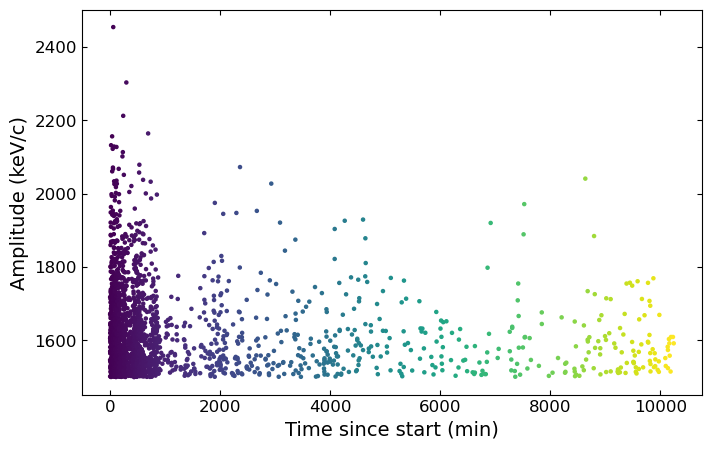

In [116]:
# colors = plt.colormaps.get_cmap('tab20b').resampled(8).colors

with h5py.File(r'/Volumes/LaCie/dm_data_processed_amp_chisquare/sphere_20250103/20250104_4e-8mbar_alignment0_long/20250104_d_0_processed.hdf5', 'r') as f:
    t0 = f['data_processed'].attrs['timestamp']
    f.close()

pulse_time_all = np.concatenate(pulse_times)
pulse_amp_all = np.concatenate(pulse_amps)

fig, ax = plt.subplots(figsize=(8, 5))
ax.scatter((pulse_time_all - t0)/60, np.abs(pulse_amp_all) * amp2kev, c=(pulse_time_all - t0)/60, cmap='viridis', s=5)

ax.set_xlabel('Time since start (min)')
ax.set_ylabel('Amplitude (keV/c)')
# plt.xlim(0, 100000)

Text(0, 0.5, 'Time between events (s)')

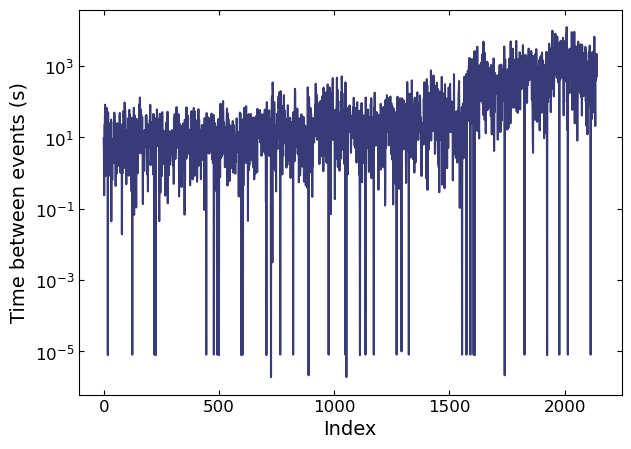

In [117]:
pulse_time_diff = np.diff(np.concatenate(pulse_times))

plt.plot(pulse_time_diff)
plt.yscale('log')

plt.xlabel('Index')
plt.ylabel('Time between events (s)')

In [120]:
file_indices.shape

(7,)

In [123]:
diff_0 = np.diff(pulse_times[0], prepend=pulse_times[0][0])

In [127]:
file_indices[0].shape

(1643,)

In [130]:
file_indices[0][diff_0 < 1e-3]

array([   0,    6,   31,   58,   60,  107,  116,  118,  120,  144,  145,
        174,  181,  211,  232,  263,  327,  405,  412,  438,  447,  461,
        513,  527,  553,  826,  858, 1001, 1088, 1145])

Take a look at the waveforms of nearby events

In [457]:
idx = 500

f = h5py.File(f'/Volumes/LaCie/dm_data_processed_amp_chisquare/sphere_20250103/20250104_4e-8mbar_alignment0_long/20250104_d_{idx}_processed.hdf5', 'r')
amplitude = f['data_processed']['amplitude'][:]
idx_in_window = f['data_processed']['idx_in_window'][:]
good_detection = f['data_processed']['good_detection'][:]
noise_level_amp = f['data_processed']['noise_level_amp'][:]
chisquare_short = f['data_processed']['chisquare_short'][:]
f.close()

amp_thr = 1500
noise_thr = 400
chi2_thr_short = 150

# 10 ms windows with good detection and noise properties
good_noise = (noise_level_amp * amp2kev) < noise_thr
good_det_noise = np.logical_and(good_detection, good_noise)

amplitude_short = np.copy(amplitude)
bad_chi2_short = (chisquare_short > chi2_thr_short)
amplitude_short[bad_chi2_short] = np.nan

pulse_window_idx = np.nonzero(np.logical_and(np.abs(amplitude_short) * amp2kev > amp_thr, np.tile(good_det_noise, (194, 1)).T))

In [35]:
indices = [3, 8, 9, 10, 13]
# indices = [96,  99, 103, 106, 116]

amps_all = []
for idx in indices:
    window_length = 5000
    f = h5py.File(f'/Volumes/LaCie/dm_data/sphere_20250103/20250104_4e-8mbar_alignment0_long/20250104_d_{idx}.hdf5', 'r')

    dtt = f['data'].attrs['delta_t']
    fs = int(np.ceil(1 / dtt))   # Sampling rate at Hz
    zz = f['data']['channel_d'][:] * f['data']['channel_d'].attrs['adc2mv'] / 1e3  # Signal in V

    zz_bp = utils.bandpass_filtered(zz, fs, 30000, 80000)

    zz_shaped = np.reshape(zz, (int(zz.size / window_length), window_length))
    zz_bp_shaped = np.reshape(zz_bp, (int(zz_bp.size / window_length), window_length))

    amps = np.empty((6000, 5000))
    for i, _zz_bp in enumerate(zz_bp_shaped):
        _amp, amp_lp, temp = utils.recon_force(dtt, _zz_bp, c_mv=None)
        amps[i] = amp_lp
        amps[i][:100] = np.nan
        amps[i][-50:] = np.nan

    amps_all.append(amps)

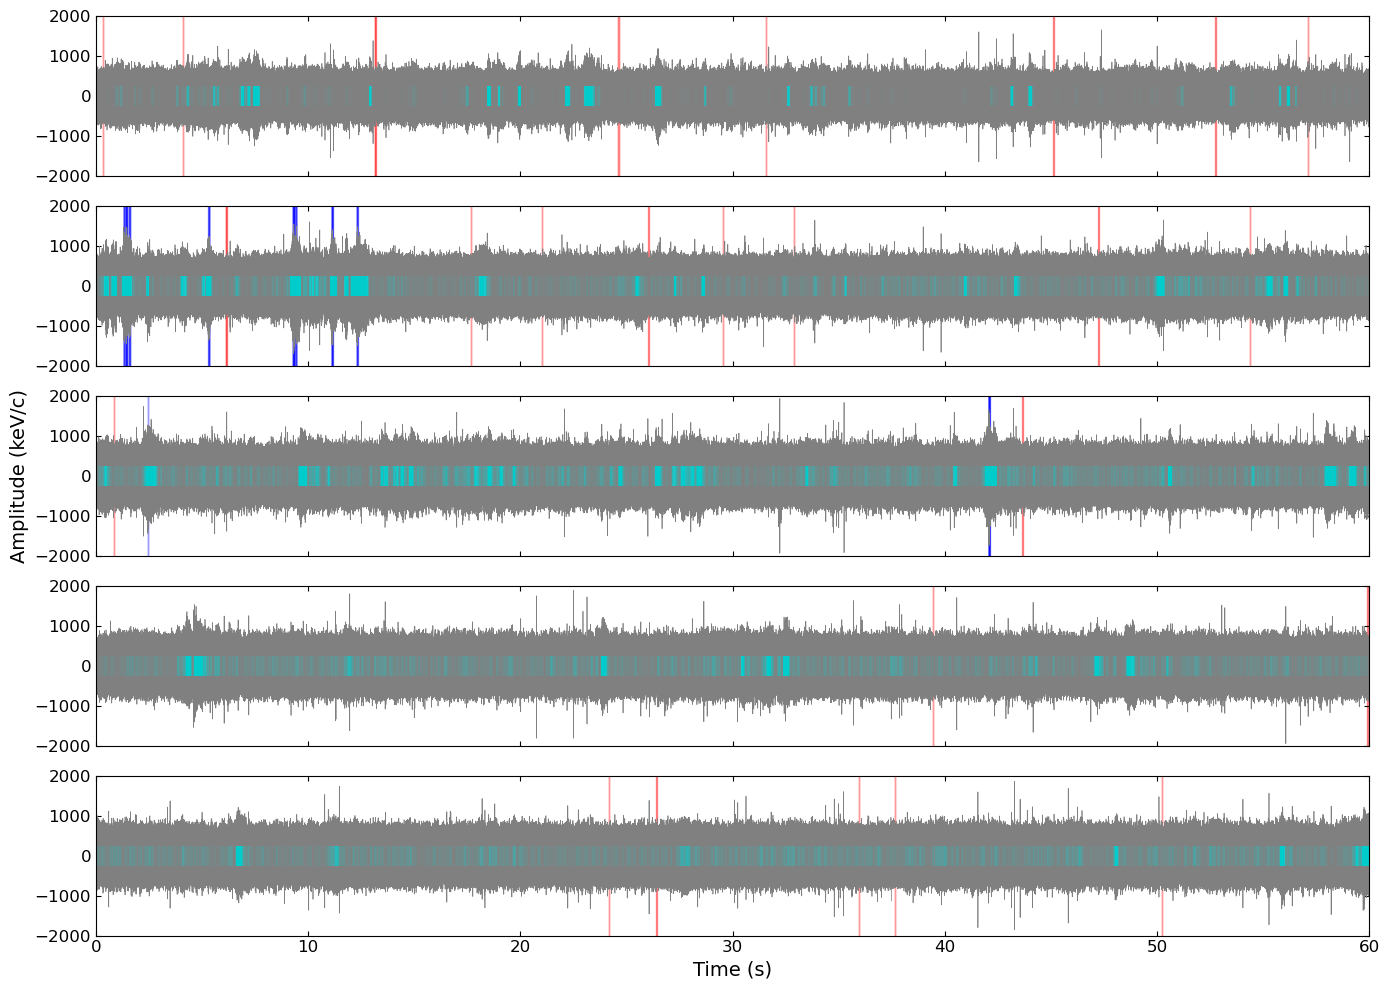

In [36]:
fig, axes = plt.subplots(5, 1, figsize=(14, 10))

noise_thr = 400
chi2_thr_short = 150
tt = np.arange(0, amps_all[0].size) * 2e-6

for i, idx_file in enumerate(indices):
    f = h5py.File(f'/Volumes/LaCie/dm_data_processed_amp_chisquare/sphere_20250103/20250104_4e-8mbar_alignment0_long/20250104_d_{idx_file}_processed.hdf5', 'r')
    # amplitude = f['data_processed']['amplitude'][:]
    idx_in_window = f['data_processed']['idx_in_window'][:]
    good_detection = f['data_processed']['good_detection'][:]
    noise_level_amp = f['data_processed']['noise_level_amp'][:]
    chisquare_short = f['data_processed']['chisquare_short'][:]
    f.close()

    bad_detection_windows = np.nonzero(~good_detection)[0]
    bad_noise_windows = np.nonzero((noise_level_amp * amp2kev) > noise_thr)[0]

    axes[i].plot(tt, np.concatenate(amps_all[i]) * amp2kev, 'grey', linewidth=0.5)

    for bad_det_win in bad_detection_windows:
        axes[i].fill_betweenx(np.linspace(-2500, 2500, 50), 5000*2e-6*bad_det_win, 5000*2e-6*(bad_det_win+1), color='r', alpha=0.4)
    for bad_noise_win in bad_noise_windows:
        axes[i].fill_betweenx(np.linspace(-2500, 2500, 50), 5000*2e-6*bad_noise_win, 5000*2e-6*(bad_noise_win+1), color='b', alpha=0.4)

    bad_chi2_short = (chisquare_short > chi2_thr_short)
    bad_chi2_pulse_time = 2e-6 * (5000 * np.nonzero(chisquare_short > chi2_thr_short)[0] + idx_in_window[chisquare_short > chi2_thr_short])
    axes[i].vlines(bad_chi2_pulse_time, -250, 250, color='cyan', alpha=0.5, linewidth=0.05)

    axes[i].set_ylim(-2000, 2000)
    axes[i].set_xlim(0, 60)

    if i != 4:
        axes[i].set_xticklabels([])

axes[4].set_xlabel('Time (s)')
axes[2].set_ylabel('Amplitude (keV/c)')

fig.tight_layout()

In [56]:
indices = [3, 8]

amps_all = []
for idx in indices:
    window_length = 5000
    f = h5py.File(f'/Volumes/LaCie/dm_data/sphere_20250103/20250111_1e-8mbar_8e_alignment1_long/20250111_d_{idx}.hdf5', 'r')

    dtt = f['data'].attrs['delta_t']
    fs = int(np.ceil(1 / dtt))   # Sampling rate at Hz
    zz = f['data']['channel_d'][:] * f['data']['channel_d'].attrs['adc2mv'] / 1e3  # Signal in V

    zz_bp = utils.bandpass_filtered(zz, fs, 30000, 80000)

    zz_shaped = np.reshape(zz, (int(zz.size / window_length), window_length))
    zz_bp_shaped = np.reshape(zz_bp, (int(zz_bp.size / window_length), window_length))

    amps = np.empty((6000, 5000))
    for i, _zz_bp in enumerate(zz_bp_shaped):
        _amp, amp_lp, temp = utils.recon_force(dtt, _zz_bp, c_mv=None)
        amps[i] = amp_lp
        amps[i][:100] = np.nan
        amps[i][-50:] = np.nan

    amps_all.append(amps)

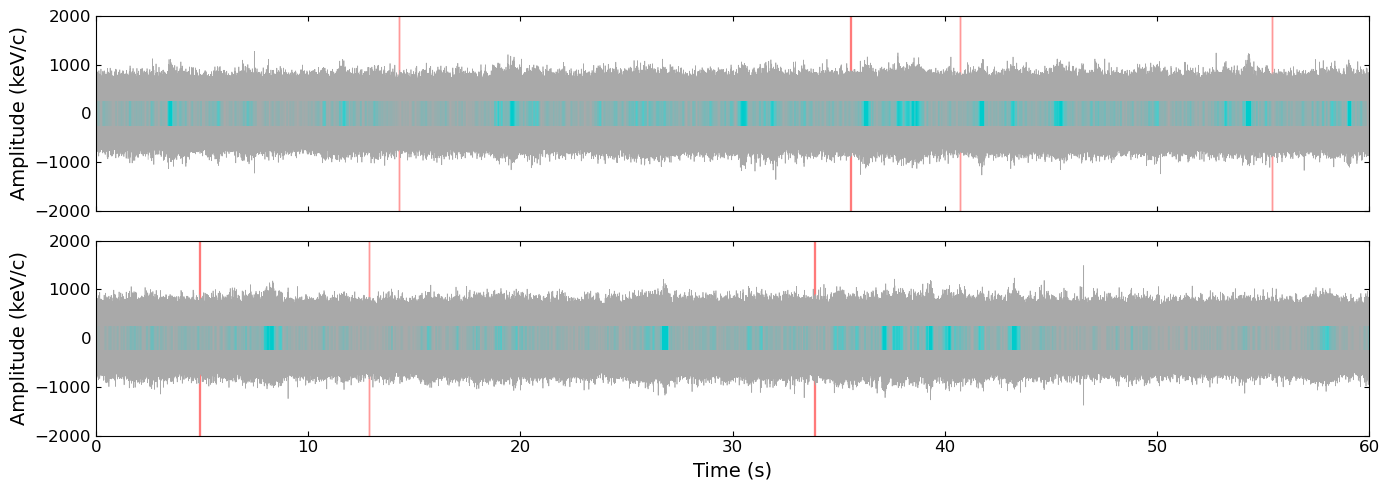

In [63]:
fig, axes = plt.subplots(2, 1, figsize=(14, 5))

noise_thr = 400
chi2_thr_short = 150
tt = np.arange(0, amps_all[0].size) * 2e-6

for i, idx_file in enumerate(indices):
    f = h5py.File(f'/Volumes/LaCie/dm_data_processed_amp_chisquare/sphere_20250103/20250111_1e-8mbar_8e_alignment1_long/20250111_d_{idx_file}_processed.hdf5', 'r')
    # amplitude = f['data_processed']['amplitude'][:]
    idx_in_window = f['data_processed']['idx_in_window'][:]
    good_detection = f['data_processed']['good_detection'][:]
    noise_level_amp = f['data_processed']['noise_level_amp'][:]
    chisquare_short = f['data_processed']['chisquare_short'][:]
    f.close()

    bad_detection_windows = np.nonzero(~good_detection)[0]
    bad_noise_windows = np.nonzero((noise_level_amp * amp2kev) > noise_thr)[0]

    axes[i].plot(tt, np.concatenate(amps_all[i]) * amp2kev, 'darkgrey', linewidth=0.5)

    for bad_det_win in bad_detection_windows:
        axes[i].fill_betweenx(np.linspace(-2500, 2500, 50), 5000*2e-6*bad_det_win, 5000*2e-6*(bad_det_win+1), color='r', alpha=0.4)
    for bad_noise_win in bad_noise_windows:
        axes[i].fill_betweenx(np.linspace(-2500, 2500, 50), 5000*2e-6*bad_noise_win, 5000*2e-6*(bad_noise_win+1), color='b', alpha=0.4)

    bad_chi2_short = (chisquare_short > chi2_thr_short)
    bad_chi2_pulse_time = 2e-6 * (5000 * np.nonzero(chisquare_short > chi2_thr_short)[0] + idx_in_window[chisquare_short > chi2_thr_short])
    axes[i].vlines(bad_chi2_pulse_time, -250, 250, color='cyan', alpha=0.5, linewidth=0.05)

    axes[i].set_ylim(-2000, 2000)
    axes[i].set_xlim(0, 60)

    if i != 1:
        axes[i].set_xticklabels([])

axes[1].set_xlabel('Time (s)')
for ax in axes:
    ax.set_ylabel('Amplitude (keV/c)')

fig.tight_layout()

1491.994111362699


Text(0, 0.5, 'Recon. amp. (keV/c)')

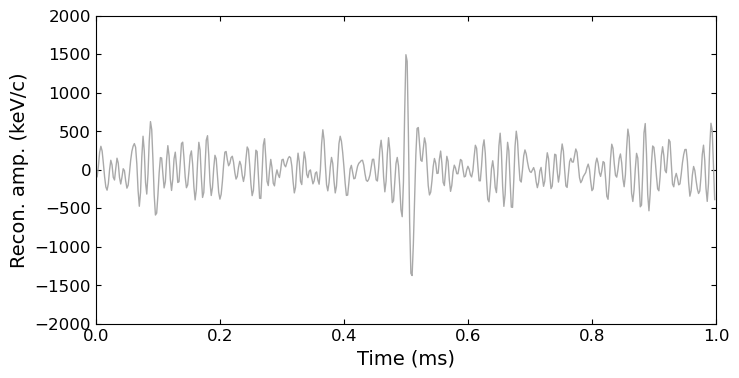

In [92]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))

idx_max = np.argmax(np.nan_to_num(np.abs(amps_all[1])))
ax.plot(np.arange(0, 500)*2e-3, np.concatenate(amps_all[1])[idx_max-250:idx_max+250]*amp2kev, 'darkgrey', linewidth=1)
print(np.concatenate(amps_all[1])[idx_max] * amp2kev)

ax.set_xlim(0, 1)
ax.set_ylim(-2000, 2000)

ax.set_xlabel('Time (ms)')
ax.set_ylabel('Recon. amp. (keV/c)')

23269228

In [88]:
len(amps_all)

6

In [15]:
np.max(np.nan_to_num(amps_all[2])) * amp2kev

1935.1459631567075

In [16]:
np.max(-1*np.nan_to_num(amps_all[2])) * amp2kev

1935.7982206721708

(1.7, 2.0)

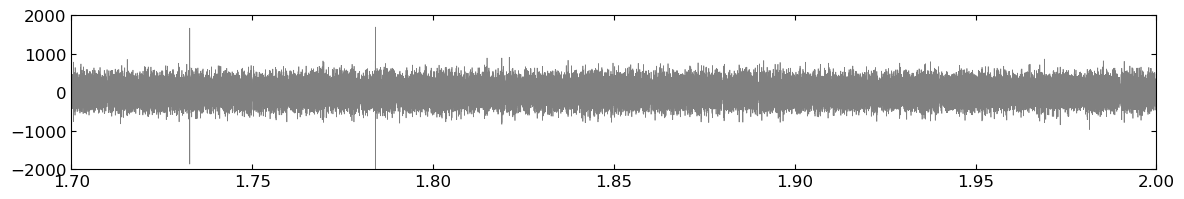

In [34]:
plt.subplots(figsize=(14, 2))

tt = np.arange(0, amps_all[0].size) * 2e-6
plt.plot(tt, np.concatenate(amps_all[2])*amp2kev, color='grey', linewidth=0.5)

plt.ylim(-2000, 2000)
plt.xlim(1.7, 2)

In [33]:
np.sum(chisquare_short > chi2_thr_short)

16234

In [467]:
amps = np.empty((194, 4850))


In [471]:
amps[0].shape

(4850,)

In [463]:
amps[0].shape

(4850,)

In [ ]:
i_window = np.arange(0, 6000)

amps = []



Text(0, 0.5, 'Amplitude (keV/c)')

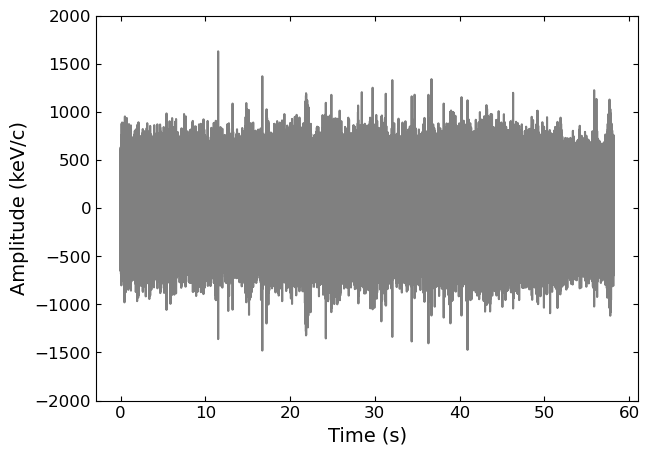

In [461]:
amps_plot = np.concatenate(amps)
tt = np.arange(0, amps_plot.size) * 2e-6

plt.plot(tt, amps_plot * amp2kev, 'grey')

# plt.xlim(0, 8)
plt.ylim(-2000, 2000)

plt.xlabel('Time (s)')
plt.ylabel('Amplitude (keV/c)')

In [393]:
def get_idx_in_window(amp_searched_idx, search_length, lb):
    ret = np.empty_like(amp_searched_idx)

    for i, amp_idx in enumerate(amp_searched_idx):
        ret[i] = amp_idx + lb + search_length * i
    
    return ret

lb, ub = 100, -50

amp_search = amp_lp[lb:ub]
amp_reshaped = np.reshape(amp_search, (int(amp_search.size/25), 25))
# amp_searched = np.max(amp_reshaped, axis=1)

# Find the index of each searched pulse in the 10 ms window
amp_searched_idx = np.argmax(amp_reshaped, axis=1)
amp_searched_idx_in_window = get_idx_in_window(amp_searched_idx, 25, lb)

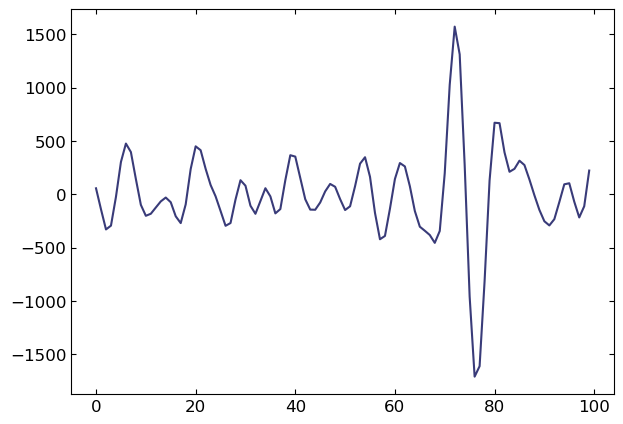

In [394]:
plt.plot(np.concatenate(amp_reshaped[7:11]) * amp2kev)
# plt.plot(amp_reshaped[158] * amp2kev)

array([   0,    0,    0, ..., 1413, 1434, 1437])

In [307]:
timestampe_file_0 = np.empty(1440)
for i in range(1440):
    with h5py.File(rf'/Volumes/LaCie/dm_data_processed_amp_chisquare/sphere_20250103/20250104_4e-8mbar_alignment0_long/20250104_d_{i}_processed.hdf5', 'r') as f:
        timestampe_file_0[i] = f['data_processed'].attrs['timestamp']
        f.close()

In [308]:
timestampe_file_0

array([1.73602951e+09, 1.73602957e+09, 1.73602963e+09, ...,
       1.73611814e+09, 1.73611820e+09, 1.73611826e+09])

In [408]:
time_diff_0 = np.diff(pulse_times[0])

In [409]:
time_diff_0

array([9.31481791e+00, 3.94083595e+00, 2.36730099e-01, ...,
       4.41464714e+02, 1.26250760e+03, 2.33684991e+02])

In [416]:
closeby_events_idx_0 = np.nonzero(np.logical_and(time_diff_0 > 1e-5, time_diff_0 < 1))[0]

In [417]:
closeby_events_idx_0

array([   2,    9,   25,   33,   37,   52,   57,   79,   81,   98,  109,
        119,  121,  132,  141,  148,  170,  188,  192,  215,  224,  241,
        246,  252,  267,  269,  276,  278,  282,  304,  327,  328,  338,
        351,  353,  375,  386,  394,  405,  422,  437,  480,  485,  499,
        505,  537,  546,  571,  586,  590,  606,  626,  653,  658,  704,
        732,  748,  775,  811,  847,  852,  869,  877,  883,  905,  985,
       1003, 1058, 1108, 1111, 1121, 1162, 1192, 1221, 1222, 1256, 1267,
       1281, 1292, 1312, 1379, 1400, 1405, 1456, 1468, 1479, 1515, 1545])

In [418]:
file_indices[0][closeby_events_idx_0 - 1]

array([  0,   3,   8,   9,  10,  13,  13,  17,  18,  25,  27,  30,  30,
        32,  35,  37,  46,  50,  50,  56,  59,  64,  65,  66,  69,  69,
        70,  70,  71,  74,  81,  81,  82,  84,  84,  91,  93,  96,  99,
       103, 106, 116, 117, 120, 121, 132, 134, 138, 140, 141, 145, 152,
       158, 158, 174, 185, 197, 216, 230, 245, 247, 250, 252, 252, 269,
       335, 357, 413, 437, 438, 442, 457, 471, 483, 483, 507, 512, 519,
       527, 539, 597, 617, 627, 717, 728, 748, 789, 822])

In [340]:
pulse_times[0][closeby_events_idx_0 - 1]

array([1.73602992e+09, 1.73603143e+09, 1.73603311e+09, 1.73603322e+09,
       1.73603613e+09, 1.73603667e+09, 1.73603684e+09, 1.73603694e+09,
       1.73603837e+09, 1.73603846e+09, 1.73604027e+09, 1.73604070e+09,
       1.73604248e+09, 1.73604382e+09, 1.73604561e+09, 1.73604972e+09,
       1.73605446e+09, 1.73605488e+09, 1.73605658e+09, 1.73605706e+09,
       1.73605798e+09, 1.73606116e+09, 1.73606203e+09, 1.73606362e+09,
       1.73608040e+09, 1.73608189e+09, 1.73609043e+09, 1.73609662e+09,
       1.73609761e+09])

In [341]:
print(pulse_amps[0][closeby_events_0 - 1])
print(pulse_amps[0][closeby_events_0])

[ 0.21383129 -0.26110002 -0.22049555 -0.21161358  0.26846405 -0.24163261
 -0.2696806  -0.25019203  0.22938072  0.22281916 -0.21230724  0.23822703
  0.21077082 -0.24998784  0.26081334  0.24685641  0.2366185  -0.21886826
  0.22484056 -0.21221918  0.21843484  0.28746181  0.22118736  0.2401401
  0.22110024 -0.21601176  0.23060594 -0.21912893  0.21207896]
[-0.22281727 -0.21868666  0.21956381  0.23821469  0.24764795  0.21771803
  0.21991184  0.23846146  0.21491109 -0.21480769  0.21923126  0.21214381
 -0.21042349  0.23818569 -0.2156821  -0.21395007 -0.2159744   0.22139988
  0.21622217  0.21871581 -0.21006347 -0.23152701  0.21234081  0.21130522
  0.2269592   0.21088869 -0.22614523  0.21497268  0.21529599]


In [342]:
print(pulse_amps[0][np.nonzero(closeby_events_0)-1] * amp2kev)

TypeError: unsupported operand type(s) for -: 'tuple' and 'int'

In [282]:
np.sum(pulse_time_diff < 1e-3)

35

In [144]:
np.nonzero(pulse_time_diff < 1e-5)

(array([357, 523]),)

In [148]:
np.concatenate(pulse_amps)[355:358]*amp2kev

array([1544.451556  , 1705.13962247, 1518.44576117])

In [82]:
pulse_amp * amp2kev

array([1546.77759211, 1671.53054644, 1717.95897675, 1501.91840075,
       1620.51627961, 1566.43608918, 1564.89215316, 1523.36757471,
       1530.52411254, 1542.06218897, 1712.67289618, 1599.43293244,
       1641.58897131, 1733.67236581, 1597.16900652, 1674.09610784,
       1564.03429147])

In [12]:
pulse_time[0]

array([1.73602952e+09, 1.73602953e+09, 1.73602953e+09, 1.73602955e+09,
       1.73602968e+09, 1.73602979e+09, 1.73602989e+09, 1.73602990e+09,
       1.73602992e+09, 1.73602992e+09, 1.73602999e+09, 1.73603001e+09,
       1.73603003e+09, 1.73603006e+09, 1.73603007e+09, 1.73603008e+09,
       1.73603009e+09, 1.73603013e+09, 1.73603013e+09, 1.73603014e+09,
       1.73603014e+09, 1.73603015e+09, 1.73603015e+09, 1.73603016e+09,
       1.73603016e+09, 1.73603018e+09, 1.73603026e+09, 1.73603029e+09,
       1.73603031e+09, 1.73603032e+09, 1.73603034e+09, 1.73603038e+09,
       1.73603038e+09, 1.73603041e+09, 1.73603041e+09, 1.73603042e+09,
       1.73603045e+09, 1.73603057e+09, 1.73603058e+09, 1.73603058e+09,
       1.73603058e+09, 1.73603061e+09, 1.73603061e+09, 1.73603062e+09,
       1.73603064e+09, 1.73603065e+09, 1.73603081e+09, 1.73603084e+09,
       1.73603085e+09, 1.73603085e+09, 1.73603096e+09, 1.73603102e+09,
       1.73603109e+09, 1.73603109e+09, 1.73603112e+09, 1.73603114e+09,
      

In [395]:
pulse_time_1.shape

(22,)

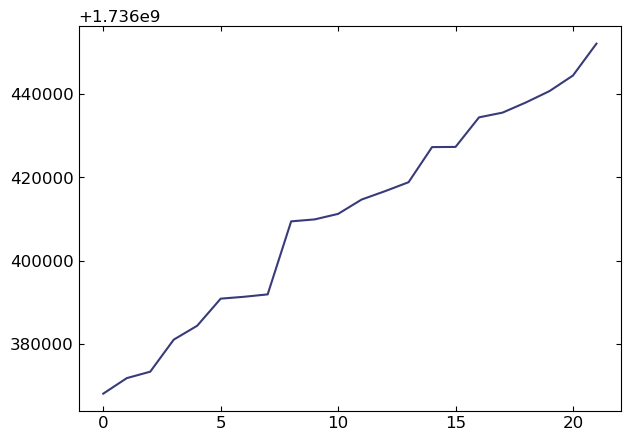

In [397]:
plt.plot(pulse_time_1)

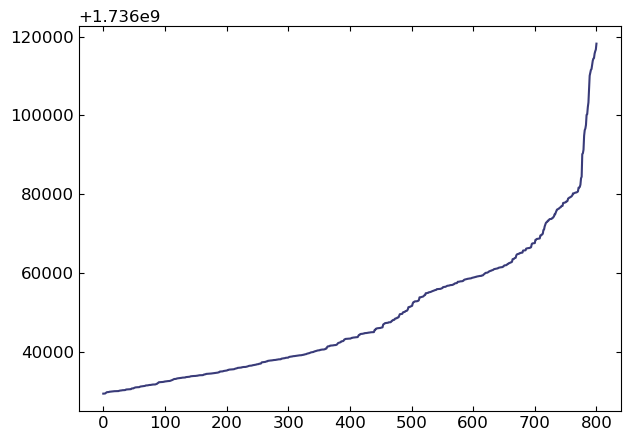

In [396]:
plt.plot(pulse_time_0)

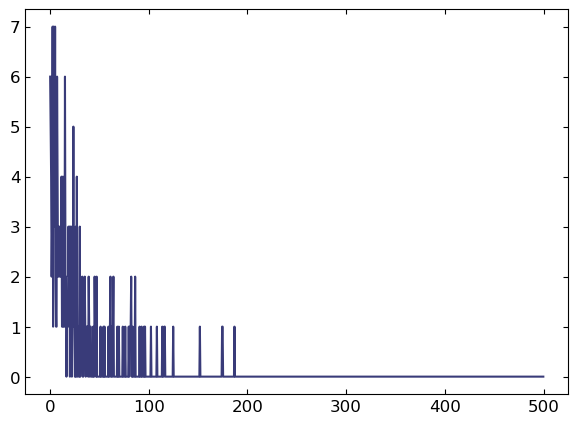

In [379]:
bins = np.linspace(0, 500, 1000)
bc = 0.5 * (bins[:-1] + bins[1:])

hh, be = np.histogram(np.diff(pulse_time), bins)
plt.plot(bc, hh)

In [378]:
np.diff(pulse_time)

array([1.32556539e+01, 2.36730099e-01, 2.19903281e+01, 1.24925859e+02,
       1.15973922e+02, 9.61966448e+01, 1.13269680e+01, 1.93835020e+01,
       5.10372591e+00, 6.39223037e+01, 1.98620353e+01, 2.38135161e+01,
       3.00434642e+01, 3.91415405e+00, 1.59129879e+01, 5.09478402e+00,
       3.91715298e+01, 7.30828190e+00, 1.67240214e+00, 8.87918186e+00,
       6.29798174e-01, 5.50390601e+00, 7.05548382e+00, 4.86094618e+00,
       1.24879060e+01, 8.00668540e+01, 3.59505119e+01, 1.42290001e+01,
       1.25175023e+01, 2.44387360e+01, 3.75613964e+01, 4.00015783e+00,
       2.45671661e+01, 2.98723197e+00, 4.09376192e+00, 3.41144702e+01,
       1.16282006e+02, 1.30565860e+01, 1.01178193e+00, 2.81960607e+00,
       2.36402359e+01, 2.75891995e+00, 7.77340913e+00, 2.61735640e+01,
       1.01353400e+01, 1.52022039e+02, 3.70448899e+01, 7.93745613e+00,
       1.37508798e+00, 1.08169547e+02, 5.93927364e+01, 6.81224277e+01,
       6.95758414e+00, 2.63589528e+01, 2.25540321e+01, 3.59858799e+00,
      

In [365]:
amplitude[pulse_window_idx] * amp2kev

array([1546.77759211, 1671.53054644, 1717.95897675, 1501.91840075])

In [348]:
good_det_noise.shape

(6000,)

In [360]:
np.tile(good_det_noise, (194, 1)).T.shape

(6000, 194)

In [345]:
amplitude[good_det_noise][pulse_window_idx] * amp2kev

array([1546.77759211, 1671.53054644, 1717.95897675, 1501.91840075])

In [337]:
pulse_window_idx

(array([1130, 2452, 2476, 4666]), array([ 24, 137,  72,  78]))

In [342]:
idx_in_window[2452, 137]

3538

In [340]:
idx_in_window[pulse_window_idx]

array([ 704, 3538, 1916, 2053], dtype=int16)

801
22


Text(0, 0.5, 'Count / (50 keV/c)')

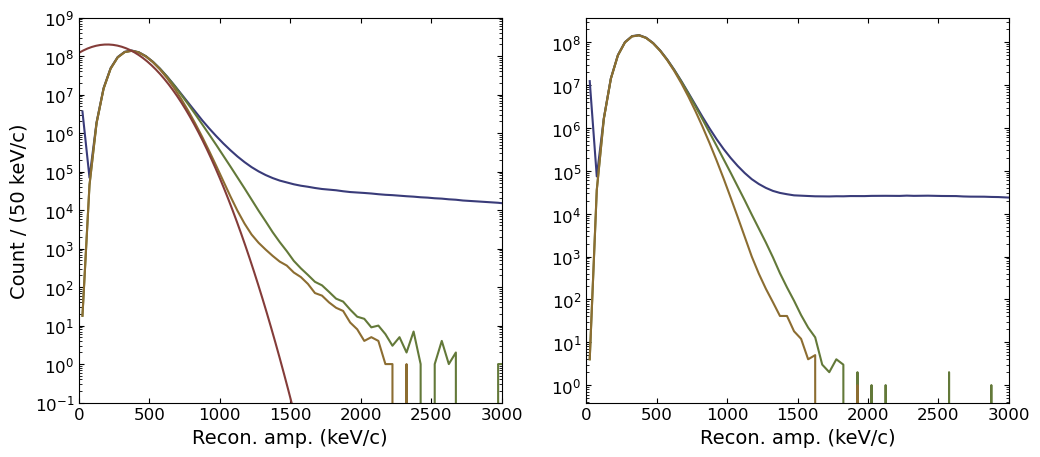

In [177]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

for i, dataset in enumerate(['20250104_4e-8mbar_alignment0_long', '20250108_1e-8mbar_8e_alignment0_long']):
    file = rf'/Volumes/LaCie/dm_data_processed_amp_chisquare/sphere_20250103/{dataset}/{dataset}_summed_histograms.hdf5'
    f = h5py.File(file, 'r')

    bc = f['summed_histograms'].attrs['bc_kev']
    hh_all_sum = f['summed_histograms']['hh_all_sum'][:]
    hh_det_sum = f['summed_histograms']['hh_det_sum'][:]
    hh_det_noise_sum = f['summed_histograms']['hh_det_noise_sum'][:]
    hh_det_noise_chi2_short_sum = f['summed_histograms']['hh_det_noise_chi2_short_sum'][:]

    f.close()

    axes[i].plot(bc, hh_all_sum)
    axes[i].plot(bc, hh_det_noise_sum)
    axes[i].plot(bc, hh_det_noise_chi2_short_sum)

    axes[i].set_yscale('log')
    axes[i].set_xlabel('Recon. amp. (keV/c)')

    axes[i].set_xlim(0, 3000)
    print(np.sum(hh_det_noise_chi2_short_sum[bc>1500]))


def gauss(x, A, mu, sigma):
    return A*np.exp(-(x-mu)**2/(2*sigma**2))
xx = np.linspace(0, 3000, 100)
axes[0].plot(xx, gauss(xx, 2e8, 200, 200))
axes[0].set_ylim(1e-1, 1e9)

axes[0].set_ylabel('Count / (50 keV/c)')


## Reconstruction

In [ ]:
def read_sphere_data(sphere):
    # data_dir = '/home/yt388/microspheres/dm_nanospheres/data_processed'
    data_dir = r'/Users/yuhan/work/nanospheres/dm_nanospheres/data_processed'

    file = f'{data_dir}/sphere_data/{sphere}_recon_all_w_nocut.h5py'
    with h5py.File(file, 'r') as fout:
        g = fout['recon_data_all']

        hists, n_windows, scalings, rates, rate_errs = [], [], [], [], []
        for i in range(4):
            hists.append(g[f'hist_{i}'][:])
            n_windows.append(g[f'hist_{i}'].attrs['n_windows'])
            scalings.append(g[f'hist_{i}'].attrs['scaling'])

            rates.append(g[f'rate_hist_{i}'][:])
            rate_errs.append(g[f'rate_hist_err_{i}'][:])
        bc = g['bc'][:]

        fout.close()

    return bc, hists, n_windows, scalings, rates, rate_errs
    

In [ ]:
bc_0, hists_0, n_windows_0, scalings_0, rates_0, rate_errs_0 = read_sphere_data('sphere_20241202')
bc_1, hists_1, n_windows_1, scalings_1, rates_1, rate_errs_1 = read_sphere_data('sphere_20250103')

In [ ]:
print(f'Cut percentage (Sphere 20241202; DQ, NL, PS): {-1 * np.diff(np.asarray(n_windows_0)) / n_windows_0[0] * 100}')
print(f'Cut percentage (Sphere 20250103; DQ, NL, PS): {-1 * np.diff(np.asarray(n_windows_1)) / n_windows_1[0] * 100}')

Cut percentage (Sphere 20241202; DQ, NL, PS): [7.04848477e+00 6.40000539e-01 5.58130344e-03]
Cut percentage (Sphere 20250103; DQ, NL, PS): [3.27918567 1.41467842 0.011878  ]


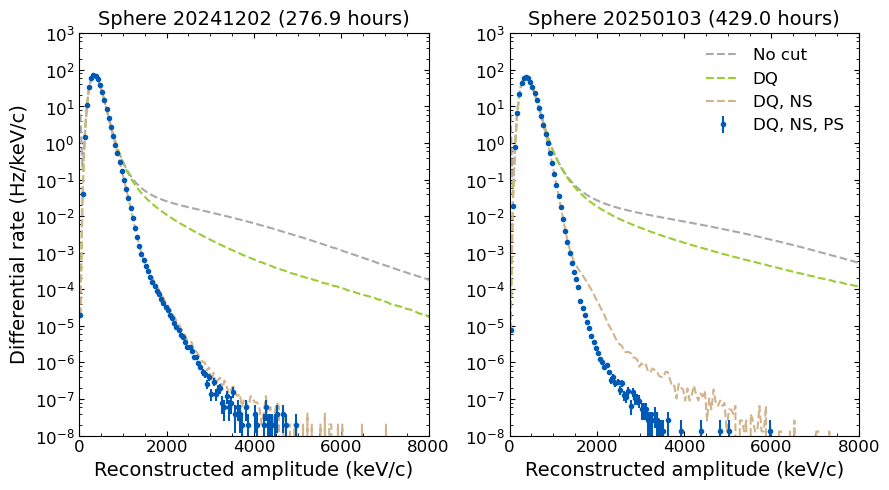

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(9, 5))

ax = axes[0]
ax.plot(bc_0, rates_0[0], '--', alpha=1, color='darkgrey')
ax.plot(bc_0, rates_0[1], '--', alpha=1, color='yellowgreen')
ax.plot(bc_0, rates_0[2], '--', alpha=1, color='tan')
ax.errorbar(bc_0, rates_0[3], yerr=rate_errs_0[3], fmt='.', color='#005AB5', alpha=1)

ax.set_title('Sphere 20241202 (276.9 hours)')
ax.set_xlabel('Reconstructed amplitude (keV/c)')
ax.set_ylabel('Differential rate (Hz/keV/c)')

ax = axes[1]
ax.plot(bc_1, rates_1[0], '--', alpha=1, label='No cut', color='darkgrey')
ax.plot(bc_1, rates_1[1], '--', alpha=1, label='DQ', color='yellowgreen')
ax.plot(bc_1, rates_1[2], '--', alpha=1, label='DQ, NS', color='tan')
ax.errorbar(bc_1, rates_1[3], yerr=rate_errs_1[3], fmt='.', color='#005AB5', alpha=1, label='DQ, NS, PS')

ax.set_title('Sphere 20250103 (429.0 hours)')
ax.set_xlabel('Reconstructed amplitude (keV/c)')
ax.legend(frameon=False)

for ax in axes:
    ax.set_yscale('log')
    # ax.set_xscale('log')

    ax.set_xlim(0, 8000)
    ax.set_ylim(1e-8, 1000)

    ax.set_yticks(np.logspace(-8, 3, 12))
    locmin = LogLocator(base=10.0, subs=(0.2, 0.4, 0.6, 0.8), numticks=15)
    ax.xaxis.set_minor_locator(MultipleLocator(500))
    ax.yaxis.set_minor_locator(locmin)
    ax.yaxis.set_minor_formatter(NullFormatter())

fig.tight_layout()

In [3]:
## Calibration values for Sphere 20250103
c_mv = 8.263269630174246e-08
amp2kev = 7396.062147743912
sigma_p = 193.80085102332893  # keV/c

In [ ]:
def get_normalized_template(sphere, voltage, downsampled=False):
    pulse_shape_file = np.load(rf'/Users/yuhan/work/nanospheres/dm_nanospheres/data_processed/pulse_shape/{sphere}_pulse_shape_template_{voltage}v.npz')
    pulse_shapes = pulse_shape_file['pulse_shape']
    pulse_shape_template = np.mean(pulse_shapes, axis=0)

    normalized_template = pulse_shape_template / np.max(pulse_shape_template)

    # Take the central 0.2 ms around the peak
    ret = normalized_template[1000:2000]

    # Downsample to 500 kHz (so the 200 us template has 100 indices)
    if downsampled:
        ret_downsampled = decimate(ret, 10)
        return ret_downsampled / np.max(ret_downsampled)
    else:
        return ret

In [62]:
np.max(normalized_template_downsampled)

1.0

In [44]:
normalized_template_downsampled = get_normalized_template('sphere_20250103', 20, True)


In [4]:
file = r'/Volumes/LaCie/dm_data/sphere_20250103/20250111_1e-8mbar_8e_alignment1_long/20250111_d_0.hdf5'

f = h5py.File(file, "r")

dtt = f['data'].attrs['delta_t']
fs = int(np.ceil(1 / dtt))   # Sampling rate at Hz
zz = f['data']['channel_d'][:] * f['data']['channel_d'].attrs['adc2mv'] / 1e3  # Signal in V

In [6]:
window_length = 5000

zz_bp = utils.bandpass_filtered(zz, fs, 30000, 80000)
zz_bp_shaped = np.reshape(zz_bp, (int(zz_bp.size / window_length), window_length))

In [77]:
_zz_bp = zz_bp_shaped[5]
_amp, amp_lp, temp = utils.recon_force(dtt, _zz_bp, c_mv)

lb, ub = 100, -50
amp_search = np.abs(amp_lp[lb:ub])
amp_reshaped = np.reshape(amp_search, (int(amp_search.size/25), 25))
amp_searched = np.max(amp_reshaped, axis=1)

In [78]:
amp_searched_idx = np.argmax(amp_reshaped, axis=1)

In [80]:
def get_idx_in_window(amp_searched_idx, search_length, lb):
    ret = np.empty_like(amp_searched_idx)

    for i, amp_idx in enumerate(amp_searched_idx):
        ret[i] = amp_idx + lb + search_length*i
    
    return ret

In [90]:
amp_searched_idx_in_window.shape

(194,)

In [82]:
amp_searched_idx_in_window = get_idx_in_window(amp_searched_idx, 25, 100)

In [ ]:
def calc_chisquares(amp_lp, indices_in_window, normalized_template, sigma_amp):
    ret = np.empty(indices_in_window.shape, np.float64)

    for i, idx in enumerate(indices_in_window):
        amp = amp_lp[idx]
        waveform = amp_lp[idx-50 : idx+50]

        # Amplitude can be negative so no need to ajust for polarity
        template_scaled = amp * normalized_template

        # Sigma should be in amplitude (not keV)
        ret[i] = np.sum( ((waveform - template_scaled)/sigma_amp)**2 )
        
    return ret

In [87]:
chisquares = calc_chisquares(amp_lp, amp_searched_idx_in_window, normalized_template_downsampled, sigma_p/amp2kev)

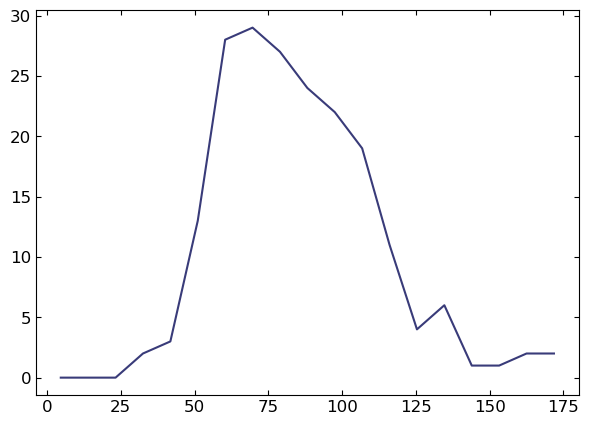

In [89]:
bins = np.linspace(0, np.max(chisquares), 20)
hh, be = np.histogram(chisquares, bins)
bc = 0.5 * (be[1:] + be[:-1])

plt.plot(bc, hh)

In [84]:
amp_lp[amp_searched_idx_in_window]

array([ 0.08772101,  0.05669152, -0.06897341,  0.05653008, -0.07798194,
        0.03708756,  0.04993439, -0.06371964, -0.03841992, -0.04374218,
        0.06077316, -0.03494775, -0.05947568, -0.06498815, -0.02708954,
        0.04122268,  0.05684673,  0.02078069,  0.03954533, -0.05486119,
       -0.05598166,  0.08086065, -0.05981752,  0.06866513,  0.04300902,
       -0.04741949,  0.03981559,  0.04895975, -0.038152  ,  0.05438   ,
       -0.06760482, -0.06856493,  0.04958079,  0.04539088,  0.06018391,
       -0.0465434 , -0.05463856, -0.04855631,  0.03943739,  0.0618602 ,
        0.07207361, -0.0671569 ,  0.06149261, -0.06339936,  0.05176493,
        0.02132841, -0.04797946,  0.05793515, -0.05199201,  0.03747432,
        0.05914015, -0.03919056, -0.03902831, -0.04452541,  0.04742779,
       -0.06319027,  0.0464343 ,  0.06232497,  0.06121025,  0.04674837,
        0.05277347, -0.04732615,  0.04276151,  0.01767062,  0.03503062,
       -0.03522466,  0.06469446, -0.06731397, -0.05377975, -0.02

In [83]:
amp_searched

array([0.08772101, 0.05669152, 0.06897341, 0.05653008, 0.07798194,
       0.03708756, 0.04993439, 0.06371964, 0.03841992, 0.04374218,
       0.06077316, 0.03494775, 0.05947568, 0.06498815, 0.02708954,
       0.04122268, 0.05684673, 0.02078069, 0.03954533, 0.05486119,
       0.05598166, 0.08086065, 0.05981752, 0.06866513, 0.04300902,
       0.04741949, 0.03981559, 0.04895975, 0.038152  , 0.05438   ,
       0.06760482, 0.06856493, 0.04958079, 0.04539088, 0.06018391,
       0.0465434 , 0.05463856, 0.04855631, 0.03943739, 0.0618602 ,
       0.07207361, 0.0671569 , 0.06149261, 0.06339936, 0.05176493,
       0.02132841, 0.04797946, 0.05793515, 0.05199201, 0.03747432,
       0.05914015, 0.03919056, 0.03902831, 0.04452541, 0.04742779,
       0.06319027, 0.0464343 , 0.06232497, 0.06121025, 0.04674837,
       0.05277347, 0.04732615, 0.04276151, 0.01767062, 0.03503062,
       0.03522466, 0.06469446, 0.06731397, 0.05377975, 0.02767778,
       0.0496261 , 0.05997322, 0.03546387, 0.04564219, 0.03642

In [79]:
amp_searched_idx

array([18,  0, 12, 21,  5, 24,  6, 13, 14,  5,  3,  2, 12, 13, 24,  3,  1,
        8, 11, 22, 22,  0, 21,  0,  0, 23,  1, 20, 11, 11,  0, 10,  2, 16,
        6, 12,  4, 17, 13, 24,  6, 24,  3, 23,  2, 15, 22,  0, 20,  2, 16,
       14, 17, 10,  9,  7,  6, 10,  1,  8, 20,  5,  9, 13, 22, 21, 23, 24,
        0,  4, 24,  0,  0, 14,  7, 10, 12,  6,  2, 24,  8, 11, 23, 23,  5,
       23,  1, 24,  3, 19, 16,  1, 13, 11,  6, 15, 10,  9, 15, 24, 18, 11,
        9, 10,  3,  9,  9,  7, 23,  1, 11, 17,  7,  8, 22,  1, 14, 24,  0,
       21, 20, 14, 22,  8,  7, 21,  2, 19,  5,  5, 17, 11, 14, 24,  2, 11,
       12, 14,  7,  2, 15, 12,  3, 11,  5, 17, 11,  9, 17, 20, 24,  4, 16,
       12, 10,  8, 21, 16, 17,  6, 12,  9,  5, 22, 20,  7,  3,  4,  4,  6,
       24,  7, 18,  7,  2,  5, 16,  6, 12,  9,  1, 16,  9, 11,  6,  1, 24,
        2,  7,  5, 18,  6, 17,  7])

In [ ]:
amp_reshaped[amp_searched_idx]

TypeError: only integer scalar arrays can be converted to a scalar index

In [75]:
np.take(amp_reshaped, amp_searched_idx, axis=0).shape

(194, 25)

In [74]:
amp_reshaped.shape

(194, 25)

In [60]:
amp_searched.shape

(194,)

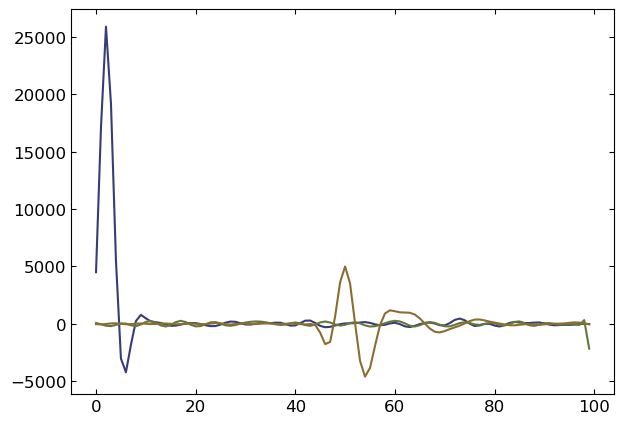

In [57]:
plt.plot(amp_lp[:100] * amp2kev )
plt.plot(amp_lp[-100:] * amp2kev )
plt.plot(normalized_template_downsampled*5000)

# plt.ylim(-1000, 1000)

In [51]:
200 / 5000

0.04

In [114]:
file = r'/Volumes/Expansion/dm_data_processed_amp_chisquare/sphere_20250103/20250104_4e-8mbar_alignment0_long/20250104_d_100_processed.hdf5'

fout = h5py.File(file, "r")
g = fout['data_processed']

amp = g['amplitude'][:]
chi2 = g['chisquare'][:]
indices = g['idx_in_window'][:]

In [120]:
amp.size

1164000

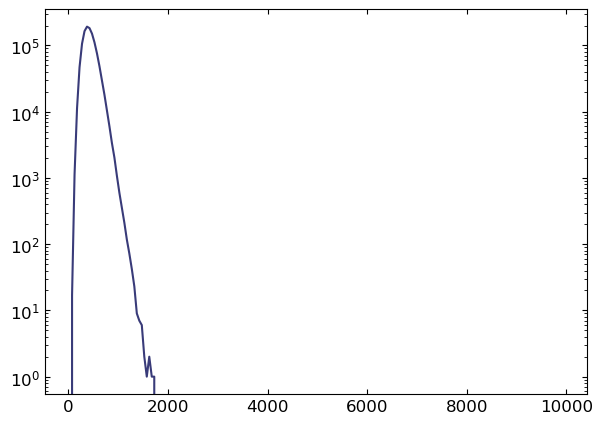

In [115]:
bins = np.arange(0, 10000, 50)  # keV
bc = 0.5 * (bins[:-1] + bins[1:])

hh, be = np.histogram(np.abs(amp.flatten())*amp2kev, bins)

plt.plot(bc, hh)
plt.yscale('log')

(0.0, 2500.0)

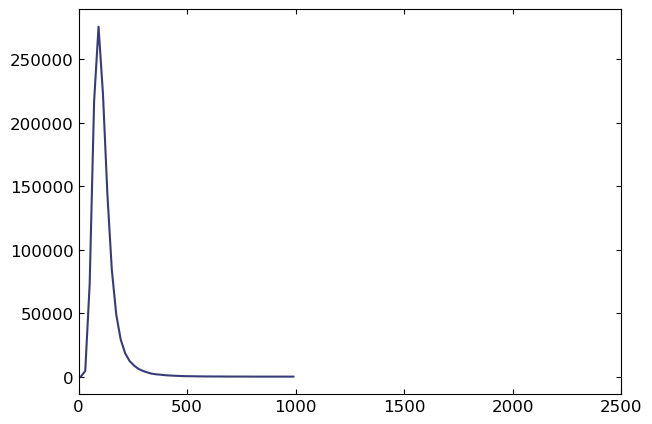

In [121]:
bins = np.linspace(0, 1000, 50)
hh, be = np.histogram(chi2.flatten(), bins)
bc = 0.5 * (be[1:] + be[:-1])

plt.plot(bc, hh)
plt.xlim(0, 2500)